In [230]:
import pandas as pd
from sklearn import datasets, linear_model, metrics
import numpy as np
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import tensorflow_decision_forests as tfdf
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt


In [231]:
train = pd.read_csv('../data/processed/train_data.csv')
test = pd.read_csv('../data/processed/test_data.csv')

In [232]:
#split input and output
X_train=train.drop(['SalePrice'], axis=1)
y_train= train['SalePrice']

X_test=test.drop(['SalePrice'], axis=1)
y_test= test['SalePrice']

In [233]:
#one hot encoding - convert categorical columns to numerical for linear regression. 
#there was an error with vanishing columns in test. This fixes it. 
X_train_one_hot = pd.get_dummies(X_train, drop_first=True) 
cols = X_train_one_hot.columns.tolist()
X_test_one_hot = pd.get_dummies(X_test, drop_first=True) 
X_test_one_hot = X_test_one_hot.reindex(columns=cols).fillna(0)


In [234]:
#Linear regression: 
#fit_intercept=False is needed as collinearity of one hot encoding, first row has to be dropped. 
reg = linear_model.LinearRegression(fit_intercept=False)
reg.fit(X_train_one_hot, y_train)

LinearRegression(fit_intercept=False)

In [235]:
#predict sales price on test set
predictions_lm = reg.predict(X_test_one_hot)

In [236]:
#Apply inverse transformation to bring predictions back to the original scale
predictions_lm = np.exp(predictions_lm)

In [237]:
#RMSE 
rms_lm = mean_squared_error(np.exp(y_test), predictions_lm, squared=False)
rms_lm

198361.3569382523

In [238]:
#tensorflow decision trees
#!pip install tensorflow_decision_forests

In [239]:
# Convert the pandas dataframe into a TensorFlow dataset
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train, label="SalePrice", task = tfdf.keras.Task.REGRESSION)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test, label="SalePrice", task = tfdf.keras.Task.REGRESSION)

In [240]:
# Create a RandomSearch tuner
tuner_rf = tfdf.tuner.RandomSearch(num_trials=20)

tuner_rf.choice("num_trees", [100, 200, 500])
tuner_rf.choice("max_depth", [-1, 10, 30])
tuner_rf.choice("min_examples", [2, 5, 10])

In [241]:
model_rf = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION, tuner=tuner_rf)
model_rf.compile

Use /var/folders/lj/1fkt9p5950q_xh36l9svgyyw0000gn/T/tmphe022kkl as temporary training directory


<bound method InferenceCoreModel.compile of <tensorflow_decision_forests.keras.RandomForestModel object at 0x14b4de0d0>>

In [244]:
model_rf.fit(train_ds)

Reading training dataset...
Training dataset read in 0:00:00.144589. Found 1165 examples.
Training model...


[INFO 25-01-05 14:20:59.9176 GMT kernel.cc:1233] Loading model from path /var/folders/lj/1fkt9p5950q_xh36l9svgyyw0000gn/T/tmphe022kkl/model/ with prefix 1b328c7624904f95


Model trained in 0:01:50.105987
Compiling model...


[INFO 25-01-05 14:21:00.7996 GMT decision_forest.cc:734] Model loaded with 500 root(s), 218842 node(s), and 80 input feature(s).
[INFO 25-01-05 14:21:00.7997 GMT abstract_model.cc:1344] Engine "RandomForestGeneric" built
[INFO 25-01-05 14:21:00.7997 GMT kernel.cc:1061] Use fast generic engine


Model compiled.


In [259]:
tuning_logs_rf = model.make_inspector().tuning_logs()
# Best hyper-parameters.
tuning_logs_rf[tuning_logs_rf.best].iloc[0]

NotFoundError: /var/folders/lj/1fkt9p5950q_xh36l9svgyyw0000gn/T/tmpg3mxo2jn/model/fca366e30d3c4cb5header.pb; No such file or directory

In [246]:
model_rf.compile(metrics=["accuracy"])
print(model_rf.evaluate(test_ds))

1/1 [==============================] - 1s 877ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
[0.0, 0.0]


In [247]:
inspector = model_rf.make_inspector()
inspector.evaluation()

Evaluation(num_examples=1165, accuracy=None, loss=None, rmse=0.15217643958890595, ndcg=None, aucs=None, auuc=None, qini=None)

In [248]:
#note this RMSE is on the logarmithic data, not the actual data! 

In [249]:
#calculate the actual RMSE
predictions_rf_log = model_rf.predict(test_ds)

1/1 [==============================] - 0s 334ms/step


In [250]:
predictions_rf=np.exp(predictions_rf_log)
y=test['SalePrice']

In [251]:
rms_rf = mean_squared_error(np.exp(y), predictions_rf, squared=False)
rms_rf

34789.15383007734

In [252]:

#next acitivity, explore all of these methods and compare RMSE of all

tfdf.keras.get_all_models()


[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

In [253]:
#GradientBoostedTreesModel - work in progress

In [254]:
# Create a RandomSearch tuner
tuner_gb = tfdf.tuner.RandomSearch(num_trials=10)

tuner_gb.choice("num_trees", [50, 100, 200, 500, 1000])
tuner_gb.choice("shrinkage", [0.01, 0.05, 0.1, 0.3, 0.5])
tuner_gb.choice("max_depth", [3, 4, 5, 6, 8, 10])
tuner_gb.choice("min_examples", [2, 5, 10, 15])



In [255]:
# Initialize and train Gradient Boosted Trees Regression model
model_gb_regressor = tfdf.keras.GradientBoostedTreesModel(
    task=tfdf.keras.Task.REGRESSION,
    tuner=tuner_gb
)

model_gb_regressor.fit(train_ds)
print("Model training complete.")

Use /var/folders/lj/1fkt9p5950q_xh36l9svgyyw0000gn/T/tmpqlzn51hx as temporary training directory
Reading training dataset...


[WARNING 25-01-05 14:22:55.9171 GMT gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 25-01-05 14:22:55.9233 GMT gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 25-01-05 14:22:55.9234 GMT gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.258755. Found 1165 examples.
Training model...
Model trained in 0:00:19.271914
Compiling model...


[INFO 25-01-05 14:23:16.4713 GMT kernel.cc:1233] Loading model from path /var/folders/lj/1fkt9p5950q_xh36l9svgyyw0000gn/T/tmpqlzn51hx/model/ with prefix db43c6aee1bb419a
[INFO 25-01-05 14:23:16.4789 GMT quick_scorer_extended.cc:911] The binary was compiled without AVX2 support, but your CPU supports it. Enable it for faster model inference.
[INFO 25-01-05 14:23:16.4804 GMT abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 25-01-05 14:23:16.4805 GMT kernel.cc:1061] Use fast generic engine


Model compiled.
Model training complete.


In [260]:
tuning_logs_gb = model_gb_regressor.make_inspector().tuning_logs()
# Best hyper-parameters.
tuning_logs_gb[tuning_logs.best].iloc[0]

NameError: name 'tuning_logs' is not defined

In [261]:
# Make predictions on test dataset
predictions_gb_log = model_gb_regressor.predict(test_ds)

# Reverse log transformation for predictions
predictions_gb = np.exp(predictions_gb_log)

# Reverse the log transformation for true variable
y=test['SalePrice']


1/1 [==============================] - 0s 343ms/step


In [262]:
# Calculate RMSE and evaluate model performance
rmse_gb = np.sqrt(mean_squared_error(np.exp(y), predictions_gb))
print(f"Root Mean Squared Error (RMSE): {rmse_gb:.2f}")

Root Mean Squared Error (RMSE): 28356.91


In [263]:
#Cart model

In [264]:
#train model
model_cm_regression = tfdf.keras.CartModel(task=tfdf.keras.Task.REGRESSION)

model_cm_regression.fit(train_ds)

Use /var/folders/lj/1fkt9p5950q_xh36l9svgyyw0000gn/T/tmpc1ryfikt as temporary training directory
Reading training dataset...
Training dataset read in 0:00:01.497015. Found 1165 examples.
Training model...
Model trained in 0:00:00.153232
Compiling model...


[INFO 25-01-05 14:27:51.6818 GMT kernel.cc:1233] Loading model from path /var/folders/lj/1fkt9p5950q_xh36l9svgyyw0000gn/T/tmpc1ryfikt/model/ with prefix 49ad6505ac5f4ee1
[INFO 25-01-05 14:27:51.6827 GMT decision_forest.cc:734] Model loaded with 1 root(s), 101 node(s), and 21 input feature(s).
[INFO 25-01-05 14:27:51.6827 GMT abstract_model.cc:1344] Engine "RandomForestGeneric" built
[INFO 25-01-05 14:27:51.6827 GMT kernel.cc:1061] Use fast generic engine


Model compiled.


In [267]:
# Make predictions on the same dataset (or test set)
predictions_log_cm = model_cm_regression.predict(test_ds)

# Reverse the log transformation (use np.exp to get the original scale)
predictions_cm = np.exp(predictions_log_cm)


1/1 [==============================] - 0s 379ms/step


In [268]:
rms_cm = mean_squared_error(np.exp(y), predictions_cm, squared=False)
rms_cm

45776.470144730156

In [269]:
#basic RF

In [273]:
regressor = RandomForestRegressor(n_estimators=100, random_state=0, oob_score=True)
regressor.fit(X_train_one_hot, y_train)

RandomForestRegressor(oob_score=True, random_state=0)

In [274]:
predictions_regressor_log = regressor.predict(X_test_one_hot)
predictions_regressor = np.exp(predictions_regressor_log)



In [275]:
mse_rf = mean_squared_error(np.exp(y_test), np.exp(predictions_regressor))
print(f'Mean Squared Error: {mse}')

/var/folders/lj/1fkt9p5950q_xh36l9svgyyw0000gn/T/ipykernel_54394/1217237964.py:1: RuntimeWarning: overflow encountered in exp
  mse_rf = mean_squared_error(np.exp(y_test), np.exp(predictions_regressor))


ValueError: Input contains infinity or a value too large for dtype('float64').

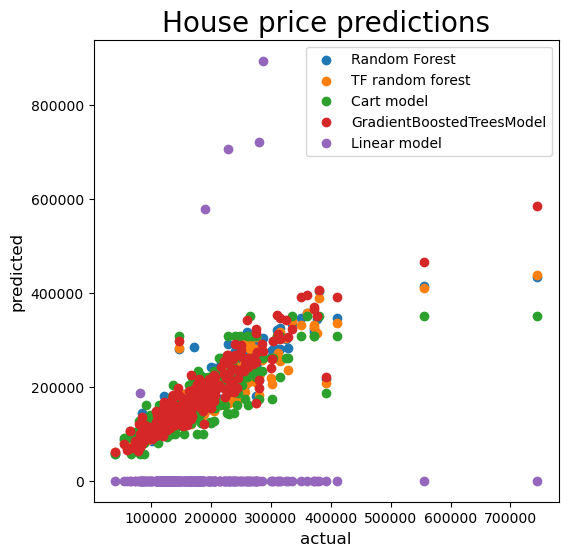

In [277]:
    fig,ax = plt.subplots(figsize=(6,6))
    ax.set_title('House price predictions',fontsize=20)
    ax.set_ylabel('predicted',fontsize=12)
    ax.set_xlabel('actual',fontsize=12)
    ax.scatter(np.exp(y_test), predictions_regressor,label='Random Forest')
    ax.scatter(np.exp(y), predictions_rf,label='TF random forest')
    ax.scatter(np.exp(y), predictions_cm,label='Cart model')
    ax.scatter(np.exp(y), predictions_gb,label='GradientBoostedTreesModel')
    ax.scatter(np.exp(y_test), predictions_lm,label='Linear model')
    ax.legend()
